In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


# Prueba de velocidad

In [22]:
t = 15 #s
rho_c = 0.805 #kg/L
P0 = 1.001 #bar
T0 = 299.8 #K
hc = 15 #cm
Hu = 42.5 #MJ/kg
alpha_Ga = 30 #Grades
b = 0.305 #m
lo = 14.3 #kg/kg
W0 = 0.118 #kN

df_velocidad = pd.read_csv('/home/heneos/Downloads/velocidad.csv')
df_velocidad

,n(rpm),F(N),Delta S(cm),V (cm^3),delta P(cm),Humo (m^-1),TH2O-e(°C),TH2O-s(°C),Tacei(°C),Paceite (psig),...,etav (%),ge(L/kW.h),eta e (%),Nelec (kWe),efic. generador (%),Mm (N.m),Nm (kW),eta m (%),Ni (kW),eta i (%)
0,2000,85,11.8,9.0,11.4,4.95,69,73,46,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1800,87,11.1,7.9,10.1,5.00,70,72,75,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1600,89,9.9,6.0,8.7,1.92,69,72,76,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1400,86,8.8,4.9,7.4,1.01,70,73,80,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1200,87,7.6,4.3,6.1,0.79,68,71,81,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1000,82,6.3,3.5,5.0,0.53,69,72,81,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
Fd = df_velocidad['F(N)']/1000 #kN
Mm = b*(W0-Fd) #kN-m
Nm = Mm*2*np.pi*df_velocidad['n(rpm)']/60 #kW
pm = 120*Nm/(df_velocidad['n(rpm)']*df_velocidad['V (cm^3)']*0.001) #MPa

Me = b*Fd #kN-m
Ne = Me*2*np.pi*df_velocidad['n(rpm)']/60 #kW

pe = 120*Ne/(df_velocidad['n(rpm)']*df_velocidad['V (cm^3)']*0.001) #MPa
pi = pm+pe

Ni = Nm+Ne #kW

Gc = 3.6*df_velocidad['V (cm^3)']*rho_c/t #kg/h

eta_i = 3600*Ni/(Hu*1000*Gc)
eta_e = 3600*Ne/(Hu*1000*Gc)
eta_m = Ne/Ni

gi = 1000*Gc/Ni #g/kWh
ge = 1000*Gc/Ne #g/kWh

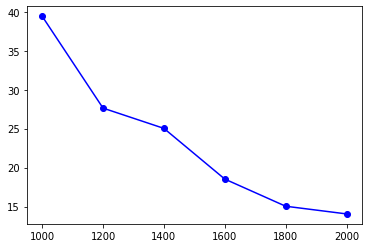

In [66]:
plt.plot(df_velocidad['n(rpm)'], pm, '-bo')

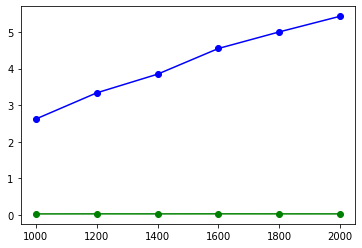

In [67]:
plt.plot(df_velocidad['n(rpm)'], Me, '-go')
plt.plot(df_velocidad['n(rpm)'], Ne, '-bo')

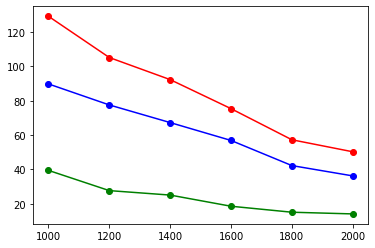

In [68]:
plt.plot(df_velocidad['n(rpm)'], pm, '-go')
plt.plot(df_velocidad['n(rpm)'], pe, '-bo')
plt.plot(df_velocidad['n(rpm)'], pi, '-ro')

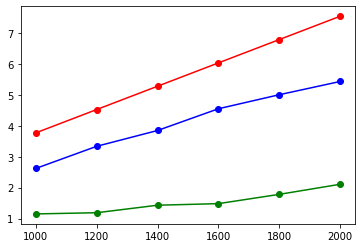

In [69]:
plt.plot(df_velocidad['n(rpm)'], Nm, '-go')
plt.plot(df_velocidad['n(rpm)'], Ne, '-bo')
plt.plot(df_velocidad['n(rpm)'], Ni, '-ro')

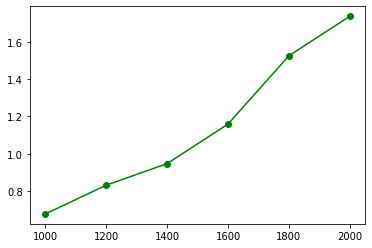

In [70]:
plt.plot(df_velocidad['n(rpm)'], Gc, '-go')

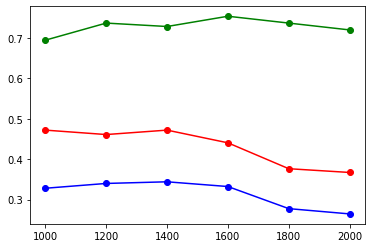

In [71]:
plt.plot(df_velocidad['n(rpm)'], eta_m, '-go')
plt.plot(df_velocidad['n(rpm)'], eta_e, '-bo')
plt.plot(df_velocidad['n(rpm)'], eta_i, '-ro')

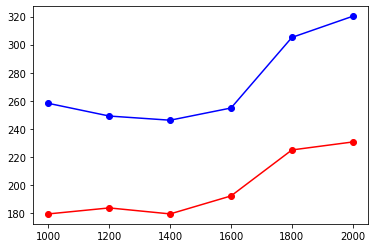

In [72]:
plt.plot(df_velocidad['n(rpm)'], ge, '-bo')
plt.plot(df_velocidad['n(rpm)'], gi, '-ro')